In [1]:
# Step 1: Import Libraries
#!pip install gensim nltk pyLDAvis
import pandas as pd
import numpy as np
import logging
import re
import gensim
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import LdaMulticore
from gensim.corpora.dictionary import Dictionary
from wordcloud import WordCloud
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 28.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.26.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:27: DeprecationWarning: invalid escape sequence '\.'
<>:27: DeprecationWarning: invalid escape sequence '\.'
<ipython-input-4-920d104d42f8>:27: DeprecationWarning: invalid escape sequence '\.'
  df['cleaned_text'] = df['employee_feedback'].apply(lambda x: re.sub('[,\.!?]', '', x).lower())
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-4-920d104d42f8>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will nev

Topic: 0 
Words: 0.013*"like" + 0.013*"staff" + 0.013*"recognition" + 0.013*"process" + 0.013*"work" + 0.009*"safety" + 0.009*"psychological" + 0.009*"feel" + 0.009*"new" + 0.009*"skills"
Topic: 1 
Words: 0.021*"feedback" + 0.021*"opportunities" + 0.014*"team" + 0.014*"provided" + 0.011*"company" + 0.011*"career" + 0.011*"good" + 0.011*"provide" + 0.011*"managers" + 0.007*"within"
Topic: 2 
Words: 0.018*"company" + 0.016*"concerns" + 0.016*"feedback" + 0.015*"like" + 0.011*"improve" + 0.011*"seem" + 0.011*"respected" + 0.011*"individuals" + 0.011*"culture" + 0.010*"sometimes"
Topic: 3 
Words: 0.043*"company" + 0.023*"feel" + 0.019*"would" + 0.019*"feedback" + 0.019*"like" + 0.016*"success" + 0.013*"investment" + 0.013*"helped" + 0.013*"see" + 0.013*"could"
Topic: 4 
Words: 0.025*"work" + 0.023*"company" + 0.022*"feel" + 0.018*"employees" + 0.017*"like" + 0.016*"would" + 0.014*"additionally" + 0.013*"available" + 0.012*"help" + 0.011*"appreciate"
Topic: 5 
Words: 0.036*"work" + 0.014*"w

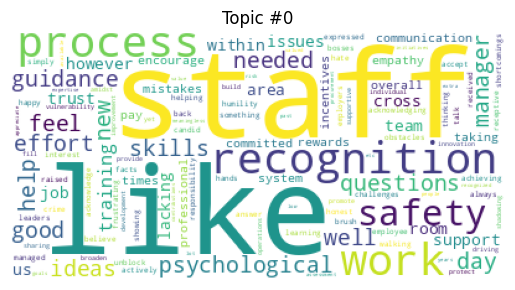

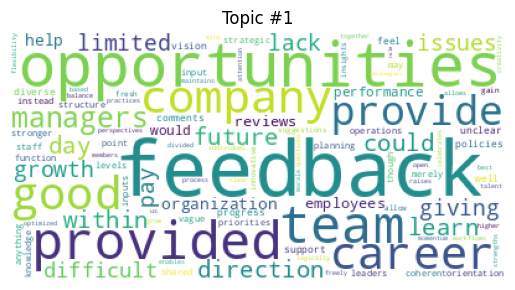

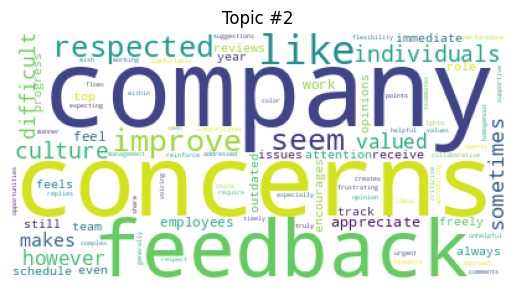

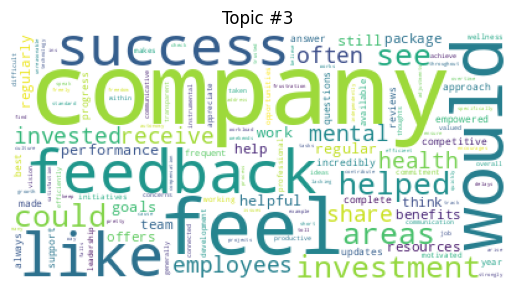

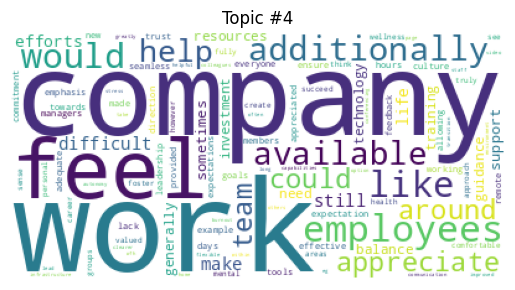

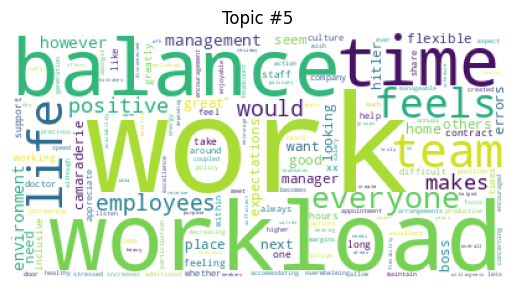

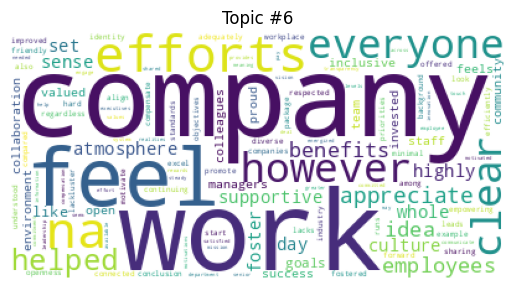

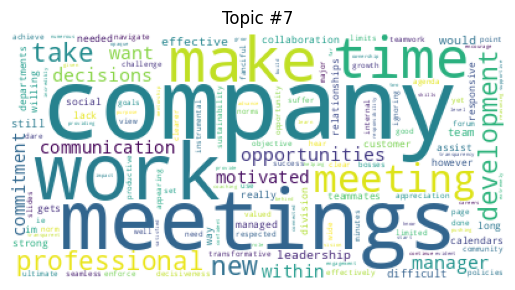

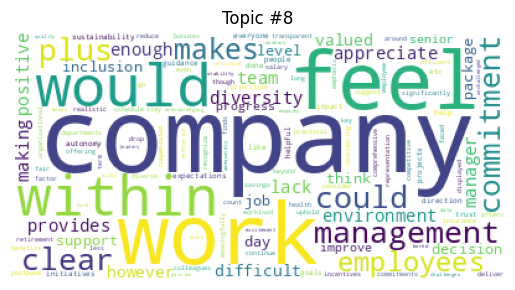

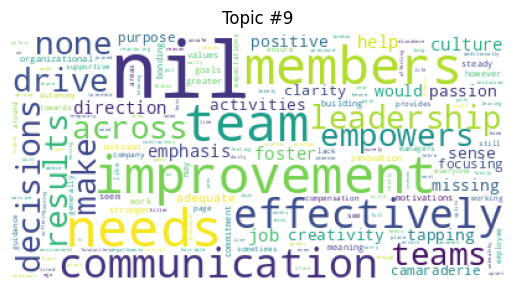

Department Dept A - Dominant Topic: 3, Average Contribution: 0.1401
Department Dept B - Dominant Topic: 4, Average Contribution: 0.2435
Department Dept C - Dominant Topic: 4, Average Contribution: 0.1429
Department Dept D - Dominant Topic: 1, Average Contribution: 0.2005


In [4]:

# Step 2: Load and Clean Data
# Replace 'DS2-assessment-simulated-employee-text.xlsx' with the actual path to your dataset file
df = pd.read_excel('/content/DS2-assessment-simulated-employee-text.xlsx')

# Preprocess the text: remove punctuation, lowercase
# Replace 'na', 'n/a', 'N/A', etc. with NaN to handle them uniformly
df['employee_feedback'].replace(to_replace=['na', 'n a','n/a', 'N/A', 'NA'], value=pd.NA, inplace=True)

# Drop rows where 'employee_feedback' is missing
df.dropna(subset=['employee_feedback'], inplace=True)

# Remove duplicates based on 'unique_identifier' and 'employee_feedback'
df.drop_duplicates(subset=['unique_identifier', 'employee_feedback'], inplace=True)
df['cleaned_text'] = df['employee_feedback'].apply(lambda x: re.sub('[,\.!?]', '', x).lower())


# Step 3: Prepare Data for LDA
stop_words = stopwords.words('english')
def tokenize(texts):
    for text in texts:
        yield(gensim.utils.simple_preprocess(str(text), deacc=True))  # deacc=True removes punctuation

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words = list(tokenize(df['cleaned_text']))
data_words_nostops = remove_stopwords(data_words)



# Create dictionary and corpus needed for Topic Modeling
dictionary = corpora.Dictionary(data_words_nostops)
corpus = [dictionary.doc2bow(text) for text in data_words_nostops]



# Setup logging to file
logging.basicConfig(filename='lda_training_log.txt', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Also add logging to console so you can see the logs there as well
console = logging.StreamHandler()
console.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s : %(levelname)s : %(message)s')
console.setFormatter(formatter)
logging.getLogger('').addHandler(console)



# Step 4: LDA Model Training
lda_model = models.LdaMulticore(corpus, id2word=dictionary, num_topics=10, passes=10)

# Step 5: Analyzing LDA Model Results
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

# Step 6: Visualization
# Word Clouds for Each Topic
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color='white').fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

# PyLDAVis
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

# Step 7: Analyze Topics by Department
doc_topics = [lda_model.get_document_topics(bow) for bow in corpus]
doc_departments = df['department'].tolist()
doc_topic_dept = [(doc_num, doc_topics[doc_num], doc_departments[doc_num]) for doc_num in range(len(doc_topics))]

from collections import defaultdict

dept_topic_aggregation = defaultdict(lambda: defaultdict(float))

for doc_num, topics, dept in doc_topic_dept:
    for topic_num, contrib in topics:
        dept_topic_aggregation[dept][topic_num] += contrib

for dept in dept_topic_aggregation:
    total_docs = sum(1 for _ in filter(lambda x: x[2] == dept, doc_topic_dept))
    for topic in dept_topic_aggregation[dept]:
        dept_topic_aggregation[dept][topic] /= total_docs

dominant_dept_topics = {dept: max(dept_topic_aggregation[dept].items(), key=lambda x: x[1]) for dept in dept_topic_aggregation}

for dept, (topic, contrib) in dominant_dept_topics.items():
    print(f"Department {dept} - Dominant Topic: {topic}, Average Contribution: {contrib:.4f}")


In [ ]:
pyLDAvis.enable_notebook()
master_path = '/content/'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
from gensim.models.coherencemodel import CoherenceModel

# Example for computing coherence score for the LDA model
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_nostops, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score:  0.4386135197822155


In [7]:
import os
import pickle
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Assuming 'num_topics' is defined or setting it directly
num_topics = 5  # This should match the number of topics you used for your LDA model

# Create the 'results' directory if it doesn't exist
os.makedirs('results', exist_ok=True)

# Prepare the LDA visualization data
LDAvis_data_filepath = './results/ldavis_prepared_' + str(num_topics) + '.pkl'

# Check if you haven't prepared the visualization data, then create it
if not os.path.isfile(LDAvis_data_filepath):
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# Load the prepared visualization data
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

# Save the interactive visualization as an HTML file
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_' + str(num_topics) + '.html')

# Print a message indicating where the HTML file is saved
print(f"Interactive LDA visualization saved as 'ldavis_prepared_{num_topics}.html'")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Interactive LDA visualization saved as 'ldavis_prepared_5.html'


In [8]:
from IPython.display import HTML

# Replace the path with the actual path to your HTML file
path_to_html = './results/ldavis_prepared_5.html'

HTML(open(path_to_html, 'r').read())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
